In [1457]:
from __future__ import print_function
from pymongo import MongoClient
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import sys
import os

import jellyfish # library for fuzzy text comparisons
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tqdm import tqdm_pandas, tqdm_notebook as tqdm
from tqdm import tqdm as tqorig
tqorig.pandas(tqdm)
from autocorrect import spell
from textblob import TextBlob

[nltk_data] Downloading package wordnet to /Users/natali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1458]:
client = MongoClient()
db     = client.fletcher
reviews   = db.reviews

In [1459]:
#cursor = reviews.find()

In [1460]:
cursor = reviews.find({},{ 'text_review Student Support': 1, 'college' : 1, 'text_review Job Prospects': 1, 'text_review Clubs and Societies':1,
                        'Student Support': 1, 'Job Prospects': 1, 'Clubs and Societies':1})

cursor = reviews.find({},{ 'text_review Student Support': 1, 'college' : 1, 'text_review Job Prospects': 1, 'text_review Clubs and Societies':1,
                         'text_review City Life': 1,'text_review Uni Facilities': 1, "text_review Student Support" : 1} )

In [1461]:
df_overall_review = pd.DataFrame(list(cursor))

In [1462]:
len(df_overall_review)*8

691440

In [1463]:
df_overall_review.tail(100)

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
86330,2.0,3.0,3,5c766b58c0bfe17384c0d1fa,University of Chichester,"it's too far to walk, i'm too tired most of th...",it's a bit too early to tell,Yes
86331,5.0,4.0,4,5c766b58c0bfe17384c0d204,Loughborough University,Good selection,The placement scheme on my course is good,Yes
86332,2.0,3.0,3,5c766b58c0bfe17384c0d20d,University of Chichester,it's hard when i don't live here,NaN,Yes
86333,2.0,4.0,4,5c766b58c0bfe17384c0d217,Loughborough University,I don't really participate because I have othe...,Constant help and support available in this area,Yes
86334,3.0,4.0,5,5c766b58c0bfe17384c0d221,"Teesside University, Middlesbrough",NaN,Amazingly!\nNot only are there plenty of servi...,Yes
86335,2.0,1.0,4,5c766b58c0bfe17384c0d22b,University of Chichester,i'm not in any - i finish uni late on Wednesda...,uni has not provided this?,Yes
86336,2.0,1.0,2,5c766b58c0bfe17384c0d235,University of Chichester,"not in any societies, so feel singled out",uni has not helped me find a job,Yes
86337,4.0,4.0,4,5c766b58c0bfe17384c0d23e,Loughborough University,It's hard to get involved in societies when yo...,Support is on hand,Yes
86338,3.0,3.0,3,5c766b58c0bfe17384c0d248,University of Chichester,lots of clubs and societies. seems like compet...,feel that my course only prepares us for certa...,Yes
86339,4.0,4.0,5,5c766b58c0bfe17384c0d252,Loughborough University,I struggle with knee problems,I feel like I should get a job by the end,Yes


In [1464]:
#df_overall_review['reviews'] = df_overall_review['text_review OVERALL UNIVERSITY RATING']
df_overall_review = df_overall_review.dropna()

In [1465]:
df_overall_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36053 entries, 0 to 86428
Data columns (total 8 columns):
Clubs and Societies                36053 non-null float64
Job Prospects                      36053 non-null float64
Student Support                    36053 non-null int64
_id                                36053 non-null object
college                            36053 non-null object
text_review Clubs and Societies    36053 non-null object
text_review Job Prospects          36053 non-null object
text_review Student Support        36053 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 2.5+ MB


In [1466]:
letters_only = lambda x: re.sub("[^a-zA-Z]", " ", str(x))
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [1467]:
df_overall_review.head()

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
0,3.0,4.0,3,5c75db20c0bfe17384b4d259,"Northumbria University, Newcastle",volunteering,careers weeks and offering placments,good support
1,3.0,4.0,5,5c75db20c0bfe17384b4d262,University of Cumbria,Good,50% of degree is spent on placement,Excellent
2,5.0,3.0,3,5c75db20c0bfe17384b4d26b,"Northumbria University, Newcastle","We have many clubs near to my home, Westgate n...",They guide us through various websites and sha...,"Support is always there, as an International s..."
3,4.0,2.0,1,5c75db20c0bfe17384b4d274,University of Hull,they are well run,they have a careers department that they try t...,never had a ast. its lacking
5,5.0,5.0,5,5c75db20c0bfe17384b4d287,"Northumbria University, Newcastle",There are a great varieties of clubs and socie...,My university provided skills development sect...,The feedback to our works are always helpful a...


In [1468]:
df_overall_review['text_review Student Support'] = df_overall_review['text_review Student Support'].map(letters_only).map(alphanumeric).map(punc_lower)

In [1469]:
df_overall_review['text_review Job Prospects'] = df_overall_review['text_review Job Prospects'].map(letters_only).map(alphanumeric).map(punc_lower)

In [1470]:
df_overall_review['text_review Clubs and Societies'] = df_overall_review['text_review Clubs and Societies'].map(letters_only).map(alphanumeric).map(punc_lower)

In [1471]:
df_overall_review.head()

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
0,3.0,4.0,3,5c75db20c0bfe17384b4d259,"Northumbria University, Newcastle",volunteering,careers weeks and offering placments,good support
1,3.0,4.0,5,5c75db20c0bfe17384b4d262,University of Cumbria,good,of degree is spent on placement,excellent
2,5.0,3.0,3,5c75db20c0bfe17384b4d26b,"Northumbria University, Newcastle",we have many clubs near to my home westgate n...,they guide us through various websites and sha...,support is always there as an international s...
3,4.0,2.0,1,5c75db20c0bfe17384b4d274,University of Hull,they are well run,they have a careers department that they try t...,never had a ast its lacking
5,5.0,5.0,5,5c75db20c0bfe17384b4d287,"Northumbria University, Newcastle",there are a great varieties of clubs and socie...,my university provided skills development sect...,the feedback to our works are always helpful a...


In [1472]:
sample = df_overall_review[df_overall_review['college'] == 'University of Oxford'][0:200]

In [1473]:
c = sample['Clubs and Societies']
j = sample['Job Prospects']
s = sample['Student Support']

In [1474]:
text = list(sample['text_review Student Support']) + list(sample['text_review Job Prospects']) + list(sample['text_review Clubs and Societies']) 

In [1475]:
text = [item for item in text]

In [1476]:
import sys
if sys.version_info[0] >= 3:
    unicode = str

In [1477]:
news = [' '.join(filter(unicode.isalpha, raw.lower().split())) for raw in
        text]

In [1478]:
news

['fantastic i myself have taken advantage of the free counselling offered',
 'academically is really good due to the tutorials but personal not so much',
 'maths academic support usually good personal support is good but the uni could do more e g longer terms to reduce stress',
 'good but could do with more of it',
 'very good personal tutor support and well funded welfare systems',
 'services are available but have limited capacity for student numbers',
 'never used it but heard a lot about it',
 'great',
 'really good',
 'rather uninformed',
 'generally my academic feedback has been thorough and helpful though the variable nature of the way teaching is organised means that some people have bad experiences my college offers a lot of welfare support',
 'could have more feedback and assistance but i guess it is more self directed',
 'minimal course or college feedback and support but good counselling service',
 'tutors feedback very good tutorial based counselling haven t had very much 

In [1479]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 3 # number of topics
n_iter = 500 # number of iterations

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(news)

# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

INFO:lda:n_documents: 216
INFO:lda:vocab_size: 36
INFO:lda:n_words: 404
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
/Users/natali/anaconda3/envs/py37/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

INFO:lda:<0> log likelihood: -2497
INFO:lda:<10> log likelihood: -1668
INFO:lda:<20> log likelihood: -1622
INFO:lda:<30> log likelihood: -1637
INFO:lda:<40> log likelihood: -1577
INFO:lda:<50> log likelihood: -1577
INFO:lda:<60> log likelihood: -1582
INFO:lda:<70> log likelihood: -1570
INFO:lda:<80> log likelihood: -1586
INFO:lda:<90> log likelihood: -1571
INFO:lda:<100> log likelihood: -1568
INFO:lda:<110> log likelihood: -1540
INFO:lda:<120> log likelihood: -1551
INFO:lda:<130> log likelihood: -1555
INFO:lda:<140> log likelihood: -1558
INFO:lda:<150> log likelihood: -1567
INFO:lda:<160> log likelihood: -1575
INFO:lda:

In [1480]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 2-D
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 216 samples in 0.000s...
[t-SNE] Computed neighbors for 216 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 216 / 216
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 29.266563
[t-SNE] KL divergence after 1000 iterations: -5.578000


In [1481]:
tsne_lda

array([[ 611.7737   ,  280.85953  ],
       [ 381.93283  , -613.6235   ],
       [ 385.6449   , -364.117    ],
       [ 611.7737   ,  280.85953  ],
       [ 552.7775   , -342.73053  ],
       [ 611.7737   ,  280.85953  ],
       [ 611.7737   ,  280.85953  ],
       [ 611.7737   ,  280.85953  ],
       [ 208.66824  ,  771.3716   ],
       [ -38.193542 ,   19.731567 ],
       [ 368.00296  ,  207.26147  ],
       [ 715.8223   ,  443.49963  ],
       [ 429.27548  ,   98.54861  ],
       [ 554.96643  , -155.52435  ],
       [ 419.40427  , -232.94855  ],
       [ 733.0173   , -229.90962  ],
       [-100.90965  , -331.69202  ],
       [ 787.1662   , -455.45053  ],
       [ 733.0173   , -229.90962  ],
       [ 787.1662   , -455.45053  ],
       [ 787.1662   , -455.45053  ],
       [  68.2604   , -425.08414  ],
       [-297.88864  , -664.7102   ],
       [ 552.7775   , -342.73053  ],
       [ 611.7737   ,  280.85953  ],
       [ 554.96643  , -155.52435  ],
       [ 179.13184  ,  410.24524  ],
 

In [1482]:
n_top_words = 3 # number of keywords we show
colormap = np.array(["#1f77b4", 'grey', 'teal'])

In [1483]:
_lda_keys = []
for i in range(X_topics.shape[0]):
    _lda_keys += X_topics[i].argmax(),

In [1484]:
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # a

In [1485]:
tsne_lda[0, 0], tsne_lda[0, 1]

(611.7737, 280.85953)

In [1486]:
#_lda_keys.replace({0:, 0:1})

In [1487]:
hey = pd.DataFrame({'x' : tsne_lda[:, 0], 'y' :tsne_lda[:, 1], 'key': _lda_keys})

In [1488]:
hey.to_csv('hey.csv')

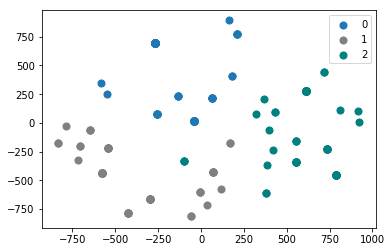

In [1489]:
cdict = {0: "#1f77b4", 1: 'grey', 2: 'teal'}
fig, ax = plt.subplots()
for g in np.unique(_lda_keys):
    ix = np.where(_lda_keys == g)
    ax.scatter(tsne_lda[ix, 0], tsne_lda[ix, 1], c = cdict[g], label = g, s = 50)
ax.legend()
plt.show()

In [1521]:
from sklearn.feature_extraction.text import TfidfTransformer

In [1522]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(news)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [1491]:
sample.head()

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
4926,4.0,5.0,5,5c75e00dc0bfe17384b57b42,University of Oxford,very extensive there s something for everybody,frequent careers fairs which i have found ver...,fantastic i myself have taken advantage of th...
4928,3.0,2.0,3,5c75e00dc0bfe17384b57b55,University of Oxford,alright but not all are easily accessible,we get weekly emails but that s it,academically is really good due to the tutoria...
4940,5.0,5.0,3,5c75e012c0bfe17384b57bc5,University of Oxford,so varied there really is something for every...,lots of useful career events,maths academic support usually good personal ...
4948,5.0,5.0,4,5c75e012c0bfe17384b57c0f,University of Oxford,lots to do easy to join,lots of career opportunities,good but could do with more of it
4951,5.0,4.0,5,5c75e014c0bfe17384b57c2b,University of Oxford,loads cheap to join,lots of careers things on offer,very good personal tutor support and well fund...


In [1492]:
clubs = pd.DataFrame(sample['text_review Clubs and Societies'].reset_index(drop= True))
clubs.columns = ['review']
job = pd.DataFrame(sample['text_review Job Prospects'].reset_index(drop= True))
job.columns = ['review']
st_sup = pd.DataFrame(sample['text_review Student Support'].reset_index(drop= True))
st_sup.columns = ['review']

In [1493]:
reviews = pd.DataFrame(columns = ['review'])

In [1494]:
reviews = reviews.append(clubs)
reviews = reviews.append(job)
reviews = reviews.append(st_sup)

In [1495]:
_lda_keys;

In [1496]:
reviews['label'] = [_lda_keys][0]

In [1497]:
reviews['polarity'] = reviews['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [1498]:
old_min = reviews['polarity'].min()
old_max = reviews['polarity'].max()
range_ = old_max - old_min

In [1499]:
a = list(c)
b = list(j)
c = list(s)

In [1500]:
a.extend(b)
a.extend(c)

In [1501]:
reviews['rating_true'] = a

In [1502]:
reviews['rating_my'] = reviews['polarity'].apply(lambda x: (x - old_min)*4/2 + 1)

In [1503]:
ls = ([0]*72 + [1]*72)

In [1504]:
ls = (ls + [2]*72)

In [1505]:
len(ls)

216

In [1506]:
reviews['label_true'] = ls

In [1507]:
reviews.head(10)

,review,label,polarity,rating_true,rating_my,label_true
0,very extensive there s something for everybody,2,0.000000,4.0,1.500000,0
1,alright but not all are easily accessible,2,0.375000,3.0,2.250000,0
2,so varied there really is something for every...,2,0.200000,5.0,1.900000,0
3,lots to do easy to join,2,0.433333,5.0,2.366667,0
4,loads cheap to join,2,0.400000,5.0,2.300000,0
5,active and welcoming,2,-0.133333,4.0,1.233333,0
6,lots to choose from,2,0.000000,4.0,1.500000,0
7,i m too lazy,2,-0.250000,1.0,1.000000,0
8,loads of options,0,0.000000,5.0,1.500000,0
9,you have everything,0,0.000000,5.0,1.500000,0


In [1508]:
import plotly.graph_objs as go

In [1509]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

x = reviews['label']

trace0 = go.Box(
    y=reviews['rating_my'],
    x=x,
    name='Accommodation',
    marker=dict(
        color='grey'
    )
)
data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='normalized moisture',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)

plot(fig)

In [1510]:
len(reviews)

216

In [1511]:
reviews['label'] = reviews['label'].replace({1:0, 0:1})

To compare with true ratings

In [1512]:
trace0 = go.Box(
    y=reviews['rating_my'],
    x=reviews['label'],
    name='Users_ratings',
    marker=dict(
        color='grey'
    )
)

trace1 = go.Box(
    y=reviews['rating_my'],
    x=reviews['label_true'],
    name='Model_ratings',
    marker=dict(
        color='teal'
    )
)


data = [trace0, trace1]
layout = go.Layout(
    yaxis=dict(
        title='rating',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'file:///Users/natali/Code/Metis/Metis-Bootcamp/projects/04-fletcher/temp-plot.html'

In [1513]:
reviews.groupby('label')['polarity'].mean()

label
0    0.244269
1    0.233590
2    0.232263
Name: polarity, dtype: float64

In [1514]:
topic_summaries

['yes really good', 'careers lots service', 'good college tutors']

In [1515]:
first_class_label = _lda_keys[401:601]   #topic 0
zero_class_label = _lda_keys[:201]
second_class_label = _lda_keys[201:401]

In [1516]:
_lda_keys;

In [1517]:
def accuracy(_lda_keys):
    count = 0
    for item in zero_class_label[0:201]:
        if item == 1:
            count += 1


In [990]:
count = 0
for item in zero_class_label:
    if item == 2:
        count += 1

In [860]:
count = 0
for item in second_class_label:
    if item == 1:
        count += 1

In [991]:
count/200

0.845

In [ ]:
from   sklearn.manifold import MDS

In [ ]:
mds = MDS(n_components=2, metric=True, dissimilarity="precomputed", random_state=2, 
          n_init=4, max_iter=6000, verbose=1)
%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)